In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [83]:
# basic parameters 
mu = 0.1
r = 0.02
S0 = 100
sigma = 0.2
K = 100
T = 0.25
# suppose we sold an at the money 1/4 year Put on the asset and we want to hedge
# we can also trade in a call option with K  = 100, T = 0.5
# $0.005 on every unit of equity traded
# $0.01 on every option traded
equity_cost = 0.005
toption_cost = 0.01
Nsim = 1000

OBJECTIVE: COMPARE MOVE-BASED AND TIME-BASED DELTA-HEDGING STRATEGY ASSUMING A BASE BAND OF 0.05

In [84]:
# helper functions 
def DeltaPut(S,K,T,t):
  Np = ( np.log(S/K) + (r + 0.5 * sigma**2) * (T - t) ) / ( sigma * np.sqrt (T - t) )
  return norm.cdf(Np) - 1
def DeltaCall(S,K,T,t):
  # N(d1) which is Put Delta + 1
  return DeltaPut(S,K,T,t) + 1
def Gamma(S,K,T,t):
    #gamma put = gamma call so we can utilize just one gamme function
    Np = ( np.log(S/K) + (r + 0.5 * sigma**2) * (T - t) ) / ( sigma * np.sqrt (T - t) )
    nd1 = (1/ np.sqrt(2*np.pi) ) *np.exp(-0.5 * Np**2)
    g = nd1 / (S * sigma * np.sqrt(T - t) )
    return g
def CallPrice(S,K,T,t,sigma):
  Np = ( np.log(S/K) + (r + 0.5 * sigma**2) * (T - t) ) / ( sigma * np.sqrt (T - t) )
  Nm = ( np.log(S/K) + (r - 0.5 * sigma**2) * (T - t) ) / ( sigma * np.sqrt (T - t) )
  return (S * norm.cdf(Np) - K * np.exp(-r * (T-t)) * norm.cdf(Nm) )

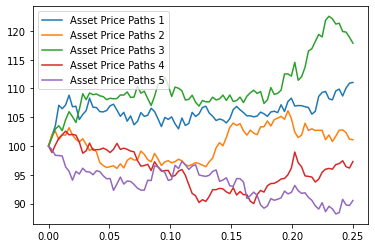

In [85]:
t = np.linspace(0,T,90) # a quarter is essentially 90 days so 90 breakpoints 
t_length = len(t)
def StockPrice(S = 100, r = 0.02, mu = 0.1, T = 0.25):
  dt = T/90
  SMAT = np.zeros( (Nsim, t_length) ) # Nsim simulations
  SMAT[:,:1] = 100 # set starting value 
  for j in range(1,t_length):
    for i in range(Nsim):
      # simulate asset price path
      SMAT[i,j] = SMAT[i,j-1] * np.exp( (mu - 0.5 * sigma**2)*dt + sigma * np.sqrt(dt) * (np.random.normal(0,1,1)) ) 
  return SMAT

S_path = StockPrice()
S_path
for path in range(5):
  plt.plot(t, S_path[path,:], label = "Asset Price Paths " + str(path + 1) ) 
plt.legend()
plt.show()

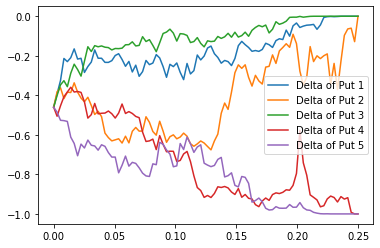

In [86]:
# now we create a delta matrix for delta hedging
DeltaPutMat = np.zeros ( (Nsim, t_length + 1) )
for j in range(t_length ):
  for i in range(Nsim):
    # if not at terminal term
    if j < (t_length ):
      DeltaPutMat[i][j] = DeltaPut(S_path[i,j], K, T, t[j]  ) # calculate delta for non-terminal prices
    else:
      if S_path[i][j] < K: # at expiry date two options
        DeltaPutMat[i][j] = -1 
      else:
        DeltaPutMat[i][j] = 0 

for path in range(5):
  plt.plot(t, DeltaPutMat[path,:-1], label = "Delta of Put " + str(path + 1) ) 
plt.legend()
plt.show()

We need to calculate the value of our position at each time sequence. Supposing we hedge daily then we can calculate the cost of our position in the following way:


*   Share Cost = [ Δ(t) - Δ(t-1) ] × S(t) × # of shares
*   Transactional Cost = # of Shares × Equity_Cost × | Δ(t) - Δ(t-1) |
*   Cost of Share Purchase = Share Cost + Transactional Cost
*   Cumulative Cost with Interest = Total Cost of Share Purchase @ (t-1) × exp(rT/days) + Share Cost @ (t) + Transactional Cost @ (t) 





In [87]:
# Now we consider delta hedging, holding only 10 share of equity and accumlate the cost
def DTHedging(S,D,tcost,r, share_amount):
  # Delta Time based hedging
  DTMAT = np.zeros( (Nsim,t_length ) )
  for i in range(Nsim):
    interest_cost = 0
    transactional_cost = 0
    share_cost = 0
    for j in range(t_length):
      if j == 0:
        share_cost = share_amount * (DeltaPutMat[i][j] ) * S_path[i][j] 
        transactional_cost =  share_amount * np.abs(DeltaPutMat[i][j]) * tcost
        DTMAT[i][j] =  share_cost + transactional_cost
      else:
        share_cost = share_amount * (DeltaPutMat[i][j] - DeltaPutMat[i][j-1]) * S_path[i][j] # cost of stock
        transactional_cost =  share_amount * np.abs(DeltaPutMat[i][j] - DeltaPutMat[i][j-1]) * tcost
        interest_cost = DTMAT[i][j-1] * np.exp(r * 0.25 / 90) 
        DTMAT[i][j] =  interest_cost + share_cost + transactional_cost
        if j == t_length -1 and S[i][j] < K:
          DTMAT[i][j] =  interest_cost + share_cost + transactional_cost + K *share_amount # have to buy shares 
      #if i ==1:
        #print(DTMAT[i][j])   
  return DTMAT[:,-1]
Delta_Time = DTHedging(S_path, DeltaPutMat,equity_cost,r, 10 )


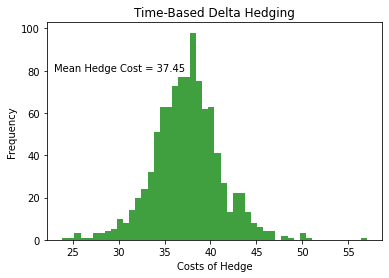

In [106]:
n, bins, patches = plt.hist(Delta_Time, 50, density=False, facecolor='g', alpha=0.75)
plt.xlabel('Costs of Hedge')
plt.ylabel('Frequency')
plt.title('Time-Based Delta Hedging')
plt.text(23, 80, r'Mean Hedge Cost = ' + str(round(Delta_Time.mean(),2) ) )
plt.show()

So looking at the distribution of costs, these results are as expected in the sense the distribution is symmetrical as the asset follows a GBM.

Looking at the second plot, we see that mean cost of delta time hedging is provided in the histogram This gives us our actual host of hedging.

Now we want to perform band based delta hedging. Now we can either have the band be flat or percentage based respective to the previous Delta. For Simplicity we will go with a flat band value. 

In [89]:
def DBHedging(S,D,tcost,r, share_amount, band_size = 0.05):
  # Delta Band based hedging
  DTMAT = np.zeros( (Nsim,t_length ) )
  for i in range(Nsim):
    interest_cost = 0
    transactional_cost = 0
    share_cost = 0
    accrue = 1
    for j in range(t_length):
      if j == 0: # base case everything is the same here
        share_cost = share_amount * (DeltaPutMat[i][j] ) * S_path[i][j] 
        transactional_cost =  share_amount * np.abs(DeltaPutMat[i][j]) * tcost
        DTMAT[i][j] =  interest_cost + share_cost + transactional_cost
        
      elif j > 0 and j < t_length - 1: # we only hedge or update our hedge if the Delta breaches the band. we set the initial band to be symmetrical around the initial delta
        if DeltaPutMat[i][j] < DeltaPutMat[i][j - accrue] - (band_size/2) or (DeltaPutMat[i][j] > DeltaPutMat[i][j - accrue] + ( band_size/2)):
          share_cost = share_amount * (DeltaPutMat[i][j] - DeltaPutMat[i][j-accrue]) * S_path[i][j] # cost of stock
          transactional_cost =  np.abs(DeltaPutMat[i][j] - DeltaPutMat[i][j-accrue]) * tcost
          interest_cost = DTMAT[i][j-accrue] * np.exp(r * accrue * 0.25 / 90)
          accrue = 1 
          DTMAT[i][j] =  interest_cost + share_cost + transactional_cost
        else: # we are in the band and dont hedge for +1 days
          accrue+=1
    # one problem we may encounter is that we take the last col of costs for the quarter and the band is not hit
    # then we will see 0 costs on that day so we should be forced to hedge on the last day to account for real costs
    # If we instead took the most recent updated cost it would not include acrued interest from that time until expiry.
      elif j == t_length - 1:
        share_cost = share_amount * (DeltaPutMat[i][j] - DeltaPutMat[i][j-accrue]) * S_path[i][j] # cost of stock
        transactional_cost =  share_amount* np.abs(DeltaPutMat[i][j] - DeltaPutMat[i][j-accrue]) * tcost
        interest_cost = DTMAT[i][j-accrue] * np.exp(r * accrue * 0.25 / 90)
        if S[i][j] > K:
          DTMAT[i][j] =  interest_cost + share_cost + transactional_cost
        else:
          DTMAT[i][j] =  interest_cost + share_cost + transactional_cost + K *share_amount # have to buy shares 
      #if i ==1:
        #print([DTMAT[i][j] , accrue ]  )   
  return DTMAT[:,-1]
Delta_Band = DBHedging(S_path, DeltaPutMat,equity_cost,r, 10,0.05 )


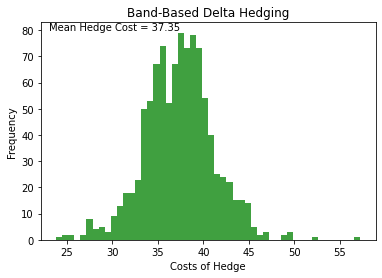

In [107]:
n, bins, patches = plt.hist(Delta_Band, 50, density=False, facecolor='g', alpha=0.75)
plt.xlabel('Costs of Hedge')
plt.ylabel('Frequency')
plt.title('Band-Based Delta Hedging')
plt.text(23, 80, r'Mean Hedge Cost = ' + str(round(Delta_Band.mean(),2) ) )
plt.show()

Cost of band-based delta  hedging given in the hist plot. band based is cheaper than time based hedging on average over 1000 simulations.

Now we want to look at these strategies using Delta-Gamma Hedging to see which strategy would be most cost effective for hedging purposes with transactions at play. For Delta-Gamma hedging we use a second option C(K=100,T=0.5) to hedge on top of the asset. The value of the portfolio is:

$V_t = α_t S_t + β_t C_t$  (bank account has to equal to this) to hedge put option $P_t$


*   $\alpha_t = \Delta_t^P - \frac{\Gamma_t^P}{\Gamma_t^C}\Delta_t^C $ is position in asset  
*   $\beta_t = \frac{\Gamma_t^P}{\Gamma_t^C}$ is option in Call option (in this case)

reference to lecture notes? or one can google as this is a common result.

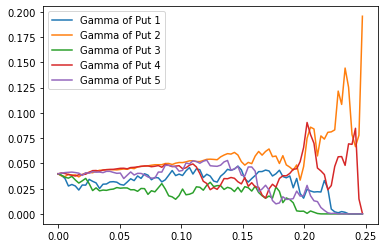

In [91]:
# We need to create two gamma matrices, one for the call and the other for the put.
# now we create a delta matrix for delta hedging
GammaPutMat = np.zeros ( (Nsim, t_length + 1) )
for j in range(t_length ):
  for i in range(Nsim):
    # if not at terminal term
    if j < (t_length ):
      GammaPutMat[i][j] = Gamma(S_path[i,j], K, T, t[j]  ) # calculate delta for non-terminal prices

for path in range(5):
  plt.plot(t, GammaPutMat[path,:-1], label = "Gamma of Put " + str(path + 1) ) 
plt.legend()
plt.show()

t2= np.linspace(0,0.5,180)
DeltaCallMat = np.zeros ( (Nsim, t_length + 1) )
for j in range(t_length ):
  for i in range(Nsim):
    # if not at terminal term
    if j < (t_length ):
      DeltaCallMat[i][j] = DeltaCall(S_path[i,j], K, 0.5, t2[j]  ) # calculate delta for non-terminal prices




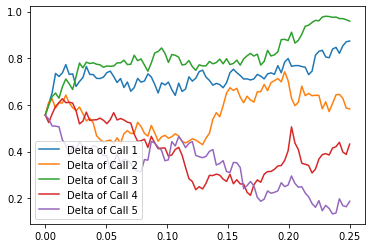

In [92]:
for path in range(5):
  plt.plot(t, DeltaCallMat[path,:-1], label = "Delta of Call " + str(path + 1) ) 
plt.legend()
plt.show()

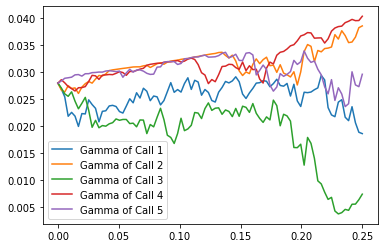

In [93]:
# We need to create two gamma matrices, one for the call and the other for the put.
# now we create a delta matrix for delta hedging

GammaCallMat = np.zeros ( (Nsim, t_length + 1) )
for j in range(t_length ):
  for i in range(Nsim):
    # if not at terminal term
    if j < (t_length ):
      GammaCallMat[i][j] = Gamma(S_path[i,j], K, 0.5, t2[j]  ) # calculate delta for non-terminal prices

for path in range(5):
  plt.plot(t, GammaCallMat[path,:-1], label = "Gamma of Call " + str(path + 1) ) 
plt.legend()
plt.show()

Now we compute the components of the portfolio which will be equal to the bank account in terms of cost. We need to calculate the value of our position at each time sequence. Supposing we hedge daily then we can calculate the cost of our position in the following way:


*   Share Cost = $(\alpha_t - \alpha_{t-1})$ × S(t) × # of shares
*   Option Cost = $( \beta_t - \beta_{t-1} )$ × # of shares × C(K,t)
*   Transactional Cost = # of Shares × [ Equity_transaction Cost × | $(\alpha_t - \alpha_{t-1})$ | + Option_transaction Cost × |$\beta_t - \beta_{t-1} $| ]
*   CumCost = Share Cost + Transactional Cost + Option Cost
*   Cumulative Cost with Interest = Total Cost of Share Purchase @ (t-1) × exp(rT/days) + Share Cost @ (t) + Transactional Cost @ (t) + Option Cost @ (t)



In [94]:
# Now we consider Gamma time hedging, holding only 10 share of equity and accumulate the cost
def GTHedging(S,D,tcost, ocost ,r, share_amount):
  # Delta Gamma Time based hedging
  GTMAT = np.zeros( (Nsim,t_length ) )
  for i in range(Nsim):
    interest_cost = 0
    transactional_cost = 0
    option_cost = 0
    share_cost = 0
    for j in range(t_length):
      if j == 0:
        beta_t = GammaPutMat[i][j] / GammaCallMat[i][j]
        alpha_t = DeltaPutMat[i][j] - beta_t * DeltaCallMat[i][j]
        share_cost = share_amount * ( alpha_t ) * S_path[i][j] 
        option_cost = (beta_t ) * share_amount * CallPrice(S_path[i][j], K, T, t[j], sigma)
        transactional_cost = share_amount * ( tcost  * np.abs(alpha_t ) + ocost * np.abs( beta_t ) )
        GTMAT[i][j] =  interest_cost + share_cost + transactional_cost +option_cost
      elif j < (t_length - 1):
        beta_t = GammaPutMat[i][j] / GammaCallMat[i][j] # beta coefficient
        beta_tm = GammaPutMat[i][j-1] / GammaCallMat[i][j-1] # beta coefficients 
        alpha_t = DeltaPutMat[i][j] - beta_t * DeltaCallMat[i][j] # alphas
        alpha_tm = DeltaPutMat[i][j-1] - beta_tm * DeltaCallMat[i][j-1]
        share_cost = share_amount * ( alpha_t - alpha_tm ) * S_path[i][j] 
        option_cost = (beta_t - beta_tm) * share_amount * CallPrice(S_path[i][j], K, 0.5, t[j], sigma)
        transactional_cost = share_amount * ( tcost  * np.abs(alpha_t - alpha_tm) + ocost * np.abs( beta_t - beta_tm ) )
        interest_cost = np.exp( r * 0.25 / 90) * GTMAT[i][j-1]
        GTMAT[i][j] =  interest_cost + share_cost + transactional_cost + option_cost
      elif (j == t_length -1):
        beta_tm = beta_t # beta coefficients 
        alpha_tm = alpha_t # previous alpha
        if S[i][j] < K:
          alpha_t = -1
          beta_t = 0
          GTMAT[i][j] += K * share_amount
        elif S[i][j] > K:
          alpha_t = 0 
          beta_t = 0
        share_cost = share_amount * ( alpha_t - alpha_tm ) * S_path[i][j] 
        option_cost = (beta_t - beta_tm) * share_amount * CallPrice(S_path[i][j], K, 0.5, t[j], sigma)
        transactional_cost = share_amount * ( tcost  * np.abs(alpha_t - alpha_tm) + ocost * np.abs( beta_t - beta_tm ) )
        interest_cost = np.exp( r * 0.25 / 90) * GTMAT[i][j-1]  
        GTMAT[i][j] +=  interest_cost + share_cost + transactional_cost +option_cost
      #if i ==5:
        #print(GTMAT[i][j])   
  return GTMAT[:,-1]
DGamma_Hedging  = GTHedging(S_path, DeltaPutMat,equity_cost,toption_cost ,r, 10 )


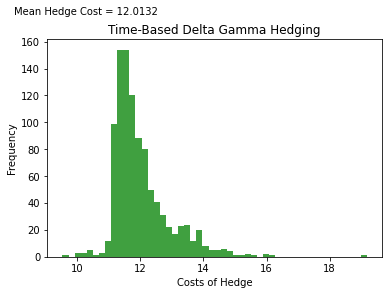

In [99]:
n, bins, patches = plt.hist(DGamma_Hedging, 50, density=False, facecolor='g', alpha=0.75)
plt.xlabel('Costs of Hedge')
plt.ylabel('Frequency')
plt.title('Time-Based Delta Gamma Hedging')
plt.text(8, 180, r'Mean Hedge Cost = ' + str(round(DGamma_Hedging.mean(),4) ) )
plt.show()

Wow! We see that Delta Gamma Hedging in general outperforms Delta Hedging. We also saw that Bnad based hedging costs less than time based hedging. We investigate it further by performing band based delta gamma hedging below.

In [96]:
# Now we consider delta Gamma band hedging, holding only 10 share of equity and accumulate the cost
# we can just edit the previous code to account for bands.
def GBHedging(S,D,tcost, ocost ,r, share_amount):
  # Delta Gamma Time based hedging
  GTMAT = np.zeros( (Nsim,t_length ) )
  for i in range(Nsim):
    interest_cost = 0
    transactional_cost = 0
    option_cost = 0
    share_cost = 0
    acrue = 1
    for j in range(t_length):
      if j == 0:
        beta_t = GammaPutMat[i][j] / GammaCallMat[i][j]
        alpha_t = DeltaPutMat[i][j] - beta_t * DeltaCallMat[i][j]
        share_cost = share_amount * ( alpha_t ) * S_path[i][j] 
        option_cost = (beta_t ) * share_amount * CallPrice(S_path[i][j], K, T, t[j], sigma)
        transactional_cost = share_amount * ( tcost  * np.abs(alpha_t ) + ocost * np.abs( beta_t ) )
        GTMAT[i][j] =  interest_cost + share_cost + transactional_cost +option_cost
        band = [alpha_t - 0.0005/2 ,alpha_t + 0.0005/2 ]
      elif j < (t_length - 1):
        beta_t = GammaPutMat[i][j] / GammaCallMat[i][j] # beta coefficient
        beta_tm = GammaPutMat[i][j-acrue] / GammaCallMat[i][j-acrue] # beta coefficients 
        alpha_t = DeltaPutMat[i][j] - beta_t * DeltaCallMat[i][j] # alphas
        alpha_tm = DeltaPutMat[i][j-acrue] - beta_tm * DeltaCallMat[i][j-acrue]
        if  alpha_t < band[0] or alpha_t > band[1]:
          share_cost = share_amount * ( alpha_t - alpha_tm ) * S_path[i][j] 
          option_cost = (beta_t - beta_tm) * share_amount * CallPrice(S_path[i][j], K, 0.5, t[j], sigma)
          transactional_cost = share_amount * ( tcost  * np.abs(alpha_t - alpha_tm) + ocost * np.abs( beta_t - beta_tm ) )
          interest_cost = np.exp( r * acrue * 0.25 / 90) * GTMAT[i][j-acrue]
          GTMAT[i][j] =  interest_cost + share_cost + transactional_cost + option_cost
          acrue = 1
          band = [alpha_t - 0.0005/2 ,alpha_t + 0.0005/2]
        else:
          acrue += 1 # counter for days accummulating interest
      elif (j == t_length - 1): # forced 
        beta_tm =  GammaPutMat[i][j-acrue] / GammaCallMat[i][j-acrue] # beta coefficients 
        alpha_tm = DeltaPutMat[i][j-acrue] - beta_tm * DeltaCallMat[i][j-acrue] # previous alpha
        if S[i][j] < K:
          alpha_t = -1
          beta_t = 0
          GTMAT[i][j] += K * share_amount
        elif S[i][j] > K:
          alpha_t = 0 
          beta_t = 0
        share_cost = share_amount * ( alpha_t - alpha_tm ) * S_path[i][j] 
        option_cost = (beta_t - beta_tm) * share_amount * CallPrice(S_path[i][j], K, 0.5, t[j], sigma)
        transactional_cost = share_amount * ( tcost  * np.abs(alpha_t - alpha_tm) + ocost * np.abs( beta_t - beta_tm ) )
        interest_cost = np.exp( r *acrue * 0.25 / 90) * GTMAT[i][j-acrue]
        GTMAT[i][j] +=  interest_cost + share_cost + transactional_cost + option_cost
        #acrue = 1
      #if i == 0 and j > 0:
       # print(beta_tm)
  return GTMAT[:,-1]
DGamma_BHedging  = GBHedging(S_path, DeltaPutMat,equity_cost,toption_cost ,r, 10 )

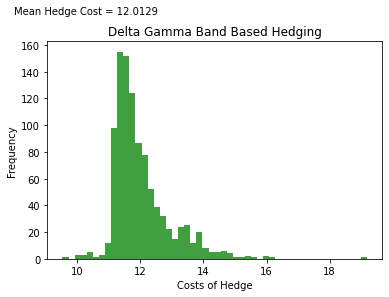

In [98]:
n, bins, patches = plt.hist(DGamma_BHedging, 50, density=False, facecolor='g', alpha=0.75)
plt.xlabel('Costs of Hedge')
plt.ylabel('Frequency')
plt.title('Delta Gamma Band Based Hedging')
plt.text(8, 183, r'Mean Hedge Cost = ' + str(round(DGamma_BHedging.mean(),4) ) )
plt.show()

We notice that Based-based hedging costs slightly less than time-based hedging.
We had the following observations:


*   Generally Delta-Gamma Hedging outperforms Delta hedging as we are more reactive to changes in Delta and not just the stock's movement
*   Band-based hedging reduces cost further as we reduce the number of transactions which are affected by transaction costs.

